In [199]:
import sys
import os
from tqdm import tqdm
import numpy as np
import torch
sys.path.append(".")
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel
from datasets import load_dataset
from accelerate import Accelerator
from torch.utils.data import DataLoader
from utils.template import TEMPLATE_DICT
import json
import pandas as pd

In [200]:
template = TEMPLATE_DICT['alpaca'][0]
MODEL_NAME = 'TinyLlama/TinyLlama_v1.1'
DATASET_NAME = "CohereForAI/aya_dataset"
DEVICE = 'cuda:0'
EVALSET_LEN = 10

In [201]:
path = 'output/aya_dataset_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20240923122624/cluster_0_checkpoint-200'

In [202]:
def load_model(path, MODEL_NAME, DEVICE):
    model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, torch_dtype=torch.float16,
                                                    quantization_config = BitsAndBytesConfig(
                                                                            load_in_4bit=True,
                                                                            bnb_4bit_use_double_quant=True,
                                                                            bnb_4bit_quant_type="nf4",
                                                                            bnb_4bit_compute_dtype=torch.bfloat16,
                                                                        ),
                                                    device_map={"": Accelerator().local_process_index})

    model = PeftModel.from_pretrained(model, path).to(DEVICE)
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, device=DEVICE, use_fast=False, padding_side="right")
    tokenizer.pad_token = tokenizer.unk_token

    return model, tokenizer

#model, tokenizer = load_model(path, MODEL_NAME, DEVICE)

In [203]:
def load_eval_data(DATASET_NAME, EVALSET_LEN, languages):
    
    dataset = load_dataset(DATASET_NAME, split="train", )
    dataset = dataset.filter(lambda x: x['language'] in ['English', 'Swedish', 'German', 'Portuguese', 'Spanish'])
    dataset_splited = dataset.train_test_split(test_size= 0.2, seed=0)
    dataset_test = dataset_splited['test']
    dataset = dataset_test.filter(lambda x: x['language'] in languages)
    dataset_len = min(len(dataset), EVALSET_LEN)
    dataset = dataset.select(range(dataset_len))

    return dataset

In [204]:
def tokenize_function(examples):
    inputs = tokenizer(examples["inputs"],   padding="max_length", truncation=True, return_tensors="pt", max_length=512)
    targets = tokenizer(examples["targets"], padding="max_length", truncation=True, return_tensors="pt", max_length=512)
    return {
        "input_ids": inputs["input_ids"].squeeze(),
        "attention_mask": inputs["attention_mask"].squeeze(),
        "labels": targets["input_ids"].squeeze()
    }

In [205]:
test_dataset = load_eval_data(DATASET_NAME, EVALSET_LEN, ['English'])

Found cached dataset parquet (/home/gabriel.talasso/.cache/huggingface/datasets/CohereForAI___parquet/default-dc0ecc36655ce556/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)
Loading cached processed dataset at /home/gabriel.talasso/.cache/huggingface/datasets/CohereForAI___parquet/default-dc0ecc36655ce556/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-a43a64b8b3c754cd.arrow
Loading cached split indices for dataset at /home/gabriel.talasso/.cache/huggingface/datasets/CohereForAI___parquet/default-dc0ecc36655ce556/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-cca2a273063fd6b6.arrow and /home/gabriel.talasso/.cache/huggingface/datasets/CohereForAI___parquet/default-dc0ecc36655ce556/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-d0cf8b2e0da0987b.arrow
Loading cached processed dataset at /home/gabriel.talasso/.cache/huggingface/datasets/CohereForAI___parquet/default-dc0ecc3665

In [206]:
import torch
from tqdm import tqdm
import numpy as np

def format_instruction(instruction, response, eos):
    template = """Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
{} 

### Response: {}{}"""

    return template.format(instruction, response, eos)

def calculate_perplexity(model, tokenizer, dataset, max_length=512):
    model.eval()
    total_loss = 0
    total_length = 0

    with torch.no_grad():
        for item in tqdm(dataset):
            # Format the input as an instruction
            input_text = format_instruction(item['inputs'], item['targets'],'')

            response = item['targets']
            #response = f'\n### Response: {response}'
            
            encodings = tokenizer(input_text, return_tensors='pt', truncation=True, max_length=max_length)
            response_encodings = tokenizer(response, return_tensors='pt', truncation=True, max_length=max_length)

            response_len = response_encodings.input_ids.size(1)

            input_ids = encodings.input_ids.to(model.device)
            target_ids = input_ids.clone()
            target_ids[:, :-response_len] = -100

            #print(tokenizer.decode(target_ids[0, -response_len:]))
            
            outputs = model(input_ids, labels=target_ids)
            loss = outputs.loss

            
            total_loss += loss.item()

    return torch.exp(torch.tensor(total_loss/ len(dataset))).item()

In [207]:
EVALSET_LEN = 10000

In [208]:
paths = ['output/aya_dataset_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20241002153817/checkpoint-1',
         'output/aya_dataset_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20241002153817/checkpoint-10',
         'output/aya_dataset_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20241002153817/checkpoint-50',
         'output/aya_dataset_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20241002153817/cluster_0_checkpoint-100',
         'output/aya_dataset_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20241002153817/cluster_1_checkpoint-100',
         'output/aya_dataset_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20241002153817/cluster_2_checkpoint-100',
         'output/aya_dataset_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20241002153817/cluster_3_checkpoint-100',
         'output/aya_dataset_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20241002153817/cluster_4_checkpoint-100',
         'output/aya_dataset_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20241002153817/cluster_0_checkpoint-150',
         'output/aya_dataset_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20241002153817/cluster_1_checkpoint-150',
         'output/aya_dataset_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20241002153817/cluster_2_checkpoint-150',
         'output/aya_dataset_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20241002153817/cluster_3_checkpoint-150',
         'output/aya_dataset_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20241002153817/cluster_4_checkpoint-150',
         'output/aya_dataset_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20241002153817/cluster_0_checkpoint-200',
         'output/aya_dataset_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20241002153817/cluster_1_checkpoint-200',
         'output/aya_dataset_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20241002153817/cluster_2_checkpoint-200',
         'output/aya_dataset_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20241002153817/cluster_3_checkpoint-200',
         'output/aya_dataset_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20241002153817/cluster_4_checkpoint-200']

languages  = ['English', 'Swedish', 'German', 'Portuguese', 'Spanish']
results = []
df = pd.DataFrame(columns=['model', 'language', 'ppl'])

#for language in languages:
#    for path in paths:
#        model, tokenizer = load_model(path, MODEL_NAME, DEVICE)
#        test_dataset = load_eval_data(DATASET_NAME, EVALSET_LEN, language)
#
#        perplexity = calculate_perplexity(model, tokenizer, test_dataset, max_length=512)
#
#        model_eval = path.split('/')[-1]
#        round = path.split('-')[-1]
#        print(f'Perplexity {model_eval}: {perplexity}')
#
#        results.append({'model': model_eval, 'round': round, 'language': language, 'ppl': perplexity})
#
#    df = pd.DataFrame(results)
#    df.to_csv('results/perplexity_fedavg.csv', index=False)

In [209]:
differences = {}
df

,model,language,ppl


In [210]:
def get_cluster_language(model, federated_type): #this code is valid for a specific experiment

    if federated_type == 'federated':
        cluster_language = 'All'

    if federated_type == 'clustered':
        try:
            if model.split('_')[1] == '0':
                cluster_language = 'Swedish'

            elif model.split('_')[1] == '1':
                cluster_language = 'English'

            elif model.split('_')[1] == '2':
                cluster_language = 'German'

            elif model.split('_')[1] == '3':
                cluster_language = 'Portuguese'

            elif model.split('_')[1] == '4':
                cluster_language = 'Spanish'

            else:
                cluster_language = '-'
        
        except IndexError:
            cluster_language = '-'

    return cluster_language

In [211]:
federated_type = 'clustered'
round = 200


In [212]:
df_results = pd.read_csv(f'results/perplexity_{federated_type}.csv')

df_results['cluster_language'] = df_results['model'].apply(lambda x: get_cluster_language(x, federated_type=federated_type))

df_results = df_results.rename(columns={'language': 'test_language'})

df_results = df_results[df_results['round'] == round]

df_results = df_results.pivot(index='cluster_language', columns='test_language', values='ppl')

df_results.to_csv(f'results/results_{federated_type}_{round}.csv')

df_results

test_language,English,German,Portuguese,Spanish,Swedish
cluster_language,,,,,
English,5.194729,6.580256,5.758704,5.874407,5.972532
German,5.986902,6.098965,6.998753,6.429470,6.513763
Portuguese,5.333992,6.537346,5.194914,5.664290,5.822595
Spanish,5.476369,6.491864,5.695516,5.098522,5.811633
Swedish,5.461677,6.622701,5.725368,5.934930,5.385089


In [213]:
values_clustered = df_results.values.diagonal()
values_clustered

array([5.19472933, 6.09896469, 5.19491434, 5.09852219, 5.38508892])

In [214]:
federated_type = 'federated'

df_results = pd.read_csv(f'results/perplexity_{federated_type}.csv')

df_results['cluster_language'] = df_results['model'].apply(lambda x: get_cluster_language(x, federated_type=federated_type))

df_results = df_results.rename(columns={'language': 'test_language'})

df_results = df_results[df_results['round'] == round]

df_results = df_results.pivot(index='cluster_language', columns='test_language', values='ppl')

df_results.to_csv(f'results/results_{federated_type}_{round}.csv')

df_results

test_language,English,German,Portuguese,Spanish,Swedish
cluster_language,,,,,
All,5.267977,6.085468,5.38426,5.326307,5.501448


In [215]:
values_federated = df_results.values[0]
values_federated

array([5.26797676, 6.08546829, 5.38426018, 5.32630682, 5.50144815])

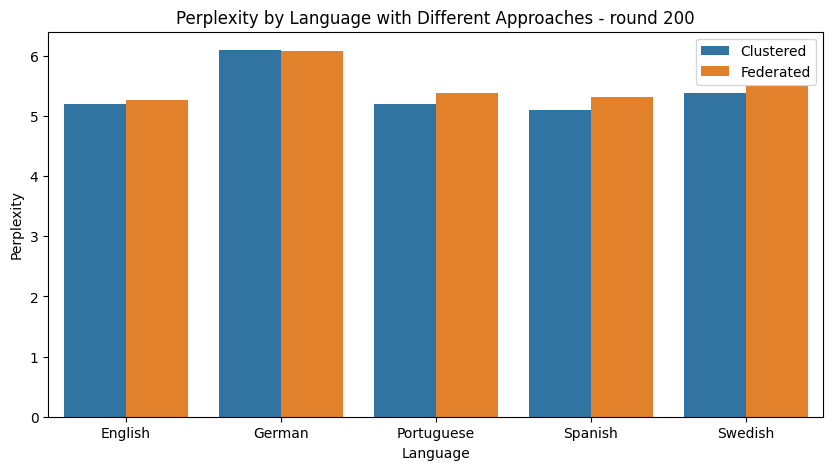

<Figure size 640x480 with 0 Axes>

In [216]:
#plor barblots for values
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

df_values = pd.DataFrame(columns=['Type', 'English','German', 'Portuguese', 'Spanish', 'Swedish'])

df_values.loc[0] = ['Clustered', values_clustered[0], values_clustered[1], values_clustered[2], values_clustered[3], values_clustered[4]]
df_values.loc[1] = ['Federated', values_federated[0], values_federated[1], values_federated[2], values_federated[3], values_federated[4]]

#pivot
df_values = df_values.melt(id_vars='Type', var_name='Language', value_name='Perplexity')

#bar plot for language splited by type
sns.barplot(data=df_values, x='Language', y='Perplexity', hue='Type', ax=ax)

plt.legend()
plt.title(f'Perplexity by Language with Different Approaches - round {round}')
plt.show()

plt.savefig(f'results/perplexity_comparison_round_{round}.png')
